
**Install requirements**

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 16     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

**Prepare Dataset**

In [4]:
# Clone github repository with data 
# Here you can find the entire dataset and a starting point to code
# Could be useful if you want to replicate the result on your own:
# clone this repo, copy the dataset as it is '101_ObjectCategories/' and put it inside
# already existing Caltech101 directory of this project
# !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

# You can follow this path to understand where to copy the dataset ;)
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

with open('Caltech101/train.txt') as f:
    train_lines = f.read().splitlines()

with open('Caltech101/test.txt') as f:
    test_lines = f.read().splitlines()

train_lines = list(filter(lambda i: i.startswith('BACKGROUND_Google/') == False, train_lines))
test_lines = list(filter(lambda i: i.startswith('BACKGROUND_Google/') == False, test_lines))

train_indexes = []
val_indexes = []

for i in range(len(train_lines)):
    if i % 2 == 0:    # Distribute 1/2 of samples on valuation set
        train_indexes.append(i)
    else:
        val_indexes.append(i)

print(len(train_dataset))
print(len(val_indexes))

test_indexes = [i for i in range(len(test_lines))]

train_sub_dataset = Subset(train_dataset, train_indexes)
val_sub_dataset = Subset(train_dataset, val_indexes)
test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_sub_dataset)))
print('Valid Dataset: {}'.format(len(val_sub_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

5784
2892
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_sub_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_sub_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [6]:
net = resnet18(pretrained=True) # Loading Resnet18 model
# net = alexnet(pretrained=True) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101


# ResNet18 outputs change
net.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES, bias=True)

# For AlexNet
# net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
# parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
# parameters_to_optimize = net.classifier.parameters() # fc layers
# parameters_to_optimize = net.features.parameters() # conv layers

# Parameters for ResNet
parameters_to_optimize = net.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [8]:
def eval_step(net, eval, acc):
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(eval):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects * 100 / float(len(val_sub_dataset))

    acc.append(round(accuracy, 2))
    #print(f'Validation Accuracy: {accuracy:.2f}%')
    net.train(True)

**Train**

In [9]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
v_acc = []
t_acc = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  eval_step(net, val_dataloader, v_acc)
  eval_step(net, train_dataloader, t_acc)

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/10, LR = [0.001]


/home/ale/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Step 0, Loss 4.731819152832031
Step 10, Loss 4.556916236877441
Step 20, Loss 3.7334237098693848
Step 30, Loss 3.179586410522461
Step 40, Loss 3.276015043258667
Step 50, Loss 2.8267011642456055
Step 60, Loss 3.820007801055908
Step 70, Loss 3.531467914581299
Step 80, Loss 3.548494815826416
Step 90, Loss 3.2244884967803955
Step 100, Loss 2.7323787212371826
Step 110, Loss 2.3430540561676025
Step 120, Loss 2.6912293434143066
Step 130, Loss 1.6911609172821045
Step 140, Loss 3.2783873081207275
Step 150, Loss 2.3902482986450195
Step 160, Loss 1.4651991128921509
Step 170, Loss 2.0813241004943848


100%|██████████| 180/180 [00:19<00:00,  9.34it/s]

Starting epoch 2/10, LR = [0.001]


Step 180, Loss 2.15606427192688
Step 190, Loss 1.9745752811431885
Step 200, Loss 1.7829898595809937
Step 210, Loss 1.7674899101257324
Step 220, Loss 1.5988560914993286
Step 230, Loss 1.3532192707061768
Step 240, Loss 1.3078479766845703
Step 250, Loss 1.9991118907928467
Step 260, Loss 1.0247708559036255
Step 270, Loss 2.0197908878326416
Step 280, Loss 2.2795236110687256
Step 290, Loss 1.609724521636963
Step 300, Loss 1.285668969154358
Step 310, Loss 0.8266608715057373
Step 320, Loss 1.0386075973510742
Step 330, Loss 0.629814088344574
Step 340, Loss 1.2995884418487549
Step 350, Loss 1.1229416131973267


100%|██████████| 180/180 [00:19<00:00,  9.34it/s]

Starting epoch 3/10, LR = [0.001]


Step 360, Loss 1.134574294090271
Step 370, Loss 0.9416018724441528
Step 380, Loss 0.6823861598968506
Step 390, Loss 0.9224304556846619
Step 400, Loss 0.8208194971084595
Step 410, Loss 0.9082944989204407
Step 420, Loss 1.1059707403182983
Step 430, Loss 0.8741041421890259
Step 440, Loss 0.8624655604362488
Step 450, Loss 0.5810208320617676
Step 460, Loss 0.5140093564987183
Step 470, Loss 0.6397280097007751
Step 480, Loss 0.6699714660644531
Step 490, Loss 0.9834945201873779
Step 500, Loss 0.7300743460655212
Step 510, Loss 0.4285394847393036
Step 520, Loss 0.6258630156517029
Step 530, Loss 0.39817917346954346


100%|██████████| 180/180 [00:19<00:00,  9.32it/s]

Starting epoch 4/10, LR = [0.001]


Step 540, Loss 0.34696367383003235
Step 550, Loss 0.3420833349227905
Step 560, Loss 0.369396448135376
Step 570, Loss 0.4702090620994568
Step 580, Loss 0.6020013689994812
Step 590, Loss 0.536391019821167
Step 600, Loss 0.40784594416618347
Step 610, Loss 0.24334824085235596
Step 620, Loss 0.6944230794906616
Step 630, Loss 0.2829839885234833
Step 640, Loss 0.48892104625701904
Step 650, Loss 0.4215823709964752
Step 660, Loss 0.4947625696659088
Step 670, Loss 0.3906692564487457
Step 680, Loss 0.29167798161506653
Step 690, Loss 0.2849089503288269
Step 700, Loss 0.3857751190662384
Step 710, Loss 0.88438880443573


100%|██████████| 180/180 [00:19<00:00,  9.34it/s]

Starting epoch 5/10, LR = [0.001]


Step 720, Loss 0.15357336401939392
Step 730, Loss 0.40209928154945374
Step 740, Loss 0.22940967977046967
Step 750, Loss 0.13328619301319122
Step 760, Loss 0.4074139893054962
Step 770, Loss 0.3205510377883911
Step 780, Loss 0.23677445948123932
Step 790, Loss 0.20745092630386353
Step 800, Loss 0.3768225908279419
Step 810, Loss 0.11181467771530151
Step 820, Loss 0.20519514381885529
Step 830, Loss 0.3370761275291443
Step 840, Loss 0.41860726475715637
Step 850, Loss 0.0634533241391182
Step 860, Loss 0.1928844153881073
Step 870, Loss 0.42951035499572754
Step 880, Loss 0.4837492108345032
Step 890, Loss 0.42053866386413574


100%|██████████| 180/180 [00:19<00:00,  9.34it/s]

Starting epoch 6/10, LR = [0.001]


Step 900, Loss 0.10332491993904114
Step 910, Loss 0.3634038269519806
Step 920, Loss 0.07034634053707123
Step 930, Loss 0.18349649012088776
Step 940, Loss 0.1907436102628708
Step 950, Loss 0.16832304000854492
Step 960, Loss 0.22542047500610352
Step 970, Loss 0.10014023631811142
Step 980, Loss 0.34593042731285095
Step 990, Loss 0.14140167832374573
Step 1000, Loss 0.17922547459602356
Step 1010, Loss 0.14923736453056335
Step 1020, Loss 0.2507796585559845
Step 1030, Loss 0.1492963582277298
Step 1040, Loss 0.216536745429039
Step 1050, Loss 0.10422169417142868
Step 1060, Loss 0.34197288751602173
Step 1070, Loss 0.18706493079662323


100%|██████████| 180/180 [00:19<00:00,  9.35it/s]

Starting epoch 7/10, LR = [0.001]


Step 1080, Loss 0.25105729699134827
Step 1090, Loss 0.11937140673398972
Step 1100, Loss 0.17913590371608734
Step 1110, Loss 0.16911375522613525
Step 1120, Loss 0.0806821808218956
Step 1130, Loss 0.06887683272361755
Step 1140, Loss 0.11214914172887802
Step 1150, Loss 0.27324023842811584
Step 1160, Loss 0.06446824967861176
Step 1170, Loss 0.17185454070568085
Step 1180, Loss 0.13130778074264526
Step 1190, Loss 0.07320675998926163
Step 1200, Loss 0.1936608850955963
Step 1210, Loss 0.26598405838012695
Step 1220, Loss 0.09003864228725433
Step 1230, Loss 0.08733399212360382
Step 1240, Loss 0.1864427626132965
Step 1250, Loss 0.42714232206344604


100%|██████████| 180/180 [00:19<00:00,  9.31it/s]

Starting epoch 8/10, LR = [0.001]


Step 1260, Loss 0.04614831134676933
Step 1270, Loss 0.10208378732204437
Step 1280, Loss 0.08785749226808548
Step 1290, Loss 0.05792895331978798
Step 1300, Loss 0.15061011910438538
Step 1310, Loss 0.13070401549339294
Step 1320, Loss 0.03141973540186882
Step 1330, Loss 0.17855165898799896
Step 1340, Loss 0.20004808902740479
Step 1350, Loss 0.04760923981666565
Step 1360, Loss 0.10482525825500488
Step 1370, Loss 0.07202024757862091
Step 1380, Loss 0.07704493403434753
Step 1390, Loss 0.07412654906511307
Step 1400, Loss 0.06718825548887253
Step 1410, Loss 0.08612527698278427
Step 1420, Loss 0.08619411289691925
Step 1430, Loss 0.13437558710575104


100%|██████████| 180/180 [00:19<00:00,  9.32it/s]

Starting epoch 9/10, LR = [0.001]


Step 1440, Loss 0.09263085573911667
Step 1450, Loss 0.0869036540389061
Step 1460, Loss 0.02658187225461006
Step 1470, Loss 0.028932983055710793
Step 1480, Loss 0.06460131704807281
Step 1490, Loss 0.05021071061491966
Step 1500, Loss 0.05033300444483757
Step 1510, Loss 0.060699351131916046
Step 1520, Loss 0.048729538917541504
Step 1530, Loss 0.05469093844294548
Step 1540, Loss 0.07384844124317169
Step 1550, Loss 0.09419798105955124
Step 1560, Loss 0.09353840351104736
Step 1570, Loss 0.04143836349248886
Step 1580, Loss 0.11427535116672516
Step 1590, Loss 0.1044154018163681
Step 1600, Loss 0.024022573605179787
Step 1610, Loss 0.13737758994102478


100%|██████████| 180/180 [00:19<00:00,  9.35it/s]

Starting epoch 10/10, LR = [0.001]


Step 1620, Loss 0.04916578158736229
Step 1630, Loss 0.04710547998547554
Step 1640, Loss 0.08730599284172058
Step 1650, Loss 0.014112986624240875
Step 1660, Loss 0.06253525614738464
Step 1670, Loss 0.05613550543785095
Step 1680, Loss 0.03571474552154541
Step 1690, Loss 0.035515349358320236
Step 1700, Loss 0.18852752447128296
Step 1710, Loss 0.018410490825772285
Step 1720, Loss 0.019879739731550217
Step 1730, Loss 0.04298979416489601
Step 1740, Loss 0.031591616570949554
Step 1750, Loss 0.04654768109321594
Step 1760, Loss 0.046796876937150955
Step 1770, Loss 0.05694793537259102
Step 1780, Loss 0.022960826754570007
Step 1790, Loss 0.08504525572061539


100%|██████████| 180/180 [00:19<00:00,  9.34it/s]


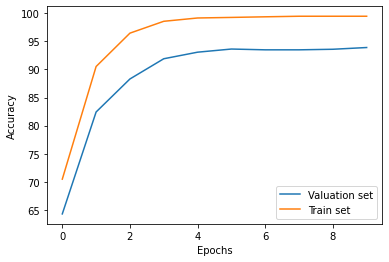

In [12]:
import matplotlib.pyplot as plt
import numpy as np
ep = np.array([i for i in range(NUM_EPOCHS)])
plt.plot(ep, v_acc, ep, t_acc)
plt.legend(('Valuation set', 'Train set'))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects * 100 / float(len(test_dataset))

print(f'Test Accuracy: {accuracy:.2f}%')

100%|██████████| 181/181 [00:19<00:00,  9.33it/s]

Test Accuracy: 93.26%
